<h2>EDA - Incident Ticket data</h2>
<h4>This notebook aims to explore the nature and composition of our raw data.  This exploration will guide the cleaning process, feature engineering, and ultimately the scope of what usable context may exist.</h4>

<ul>
    <li>Inspect data composition</li>
    <li>Infer data context and signifigance</li>
    <li>Hypothesize use cases</li>
    <li>Outline cleaning / treatment plan</li>
</ul>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

data = pd.read_csv("../data/raw/ITSM_data-Copy1.csv")

C:\Users\thoma\AppData\Local\Temp\ipykernel_18732\3217554195.py:5: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("../data/raw/ITSM_data-Copy1.csv")


<h1>--Inspect data composition--</h1>

<h3>Data Sample</h3>

In [2]:
data.head(3)

,CI_Name,CI_Cat,CI_Subcat,WBS,Incident_ID,Status,Impact,Urgency,Priority,number_cnt,...,Reopen_Time,Resolved_Time,Close_Time,Handle_Time_hrs,Closure_Code,No_of_Related_Interactions,Related_Interaction,No_of_Related_Incidents,No_of_Related_Changes,Related_Change
0,SUB000508,subapplication,Web Based Application,WBS000162,IM0000004,Closed,4,4,4.0,0.601292,...,NaN,4/11/2013 13:50,4/11/2013 13:51,"3,87,16,91,111",Other,1.0,SD0000007,2.0,NaN,NaN
1,WBA000124,application,Web Based Application,WBS000088,IM0000005,Closed,3,3,3.0,0.415050,...,2/12/2013 12:31,2/12/2013 12:36,2/12/2013 12:36,"4,35,47,86,389",Software,1.0,SD0000011,1.0,NaN,NaN
2,DTA000024,application,Desktop Application,WBS000092,IM0000006,Closed,NS,3,NaN,0.517551,...,NaN,13-01-2014 15:12,13-01-2014 15:13,"4,84,31,19,444",No error - works as designed,1.0,SD0000017,NaN,NaN,NaN


<h3>Datatype by column</h3>

All of our data types are strings, including the features representing numerical values.  Many of the columns will need converted to numerical discrete, and ordinal features.

In [3]:
for column in data.columns:
    print(f'{column} is type: {type(column)}')

CI_Name is type: <class 'str'>
CI_Cat is type: <class 'str'>
CI_Subcat is type: <class 'str'>
WBS is type: <class 'str'>
Incident_ID is type: <class 'str'>
Status is type: <class 'str'>
Impact is type: <class 'str'>
Urgency is type: <class 'str'>
Priority is type: <class 'str'>
number_cnt is type: <class 'str'>
Category is type: <class 'str'>
KB_number is type: <class 'str'>
Alert_Status is type: <class 'str'>
No_of_Reassignments is type: <class 'str'>
Open_Time is type: <class 'str'>
Reopen_Time is type: <class 'str'>
Resolved_Time is type: <class 'str'>
Close_Time is type: <class 'str'>
Handle_Time_hrs is type: <class 'str'>
Closure_Code is type: <class 'str'>
No_of_Related_Interactions is type: <class 'str'>
Related_Interaction is type: <class 'str'>
No_of_Related_Incidents is type: <class 'str'>
No_of_Related_Changes is type: <class 'str'>
Related_Change is type: <class 'str'>


<h3>Null count</h3>

With total sample size of 46,606 we can drop the rows with null values in certain columns (CI_CAT, CI_subcat etc).  For certain columns with high counts of null (related incidents / change columns, reopen time) we will need to take a closer look to identify if we can engineer meaningful context (calculate time-open possibly?) or if the columns can be dropped.

In [4]:
print(data.isnull().sum())
len(data)

CI_Name                           0
CI_Cat                          111
CI_Subcat                       111
WBS                               0
Incident_ID                       0
Status                            0
Impact                            0
Urgency                           0
Priority                       1380
number_cnt                        0
Category                          0
KB_number                         0
Alert_Status                      0
No_of_Reassignments               1
Open_Time                         0
Reopen_Time                   44322
Resolved_Time                  1780
Close_Time                        0
Handle_Time_hrs                   1
Closure_Code                    460
No_of_Related_Interactions      114
Related_Interaction               0
No_of_Related_Incidents       45384
No_of_Related_Changes         46046
Related_Change                46046
dtype: int64


46606

<h3>Check distributions of CI rates</h3>

The nex few cells illustrate a relationship between CI count and CI.  
There appears to be a very lopided distribution of CI rate among the 
unique CIs, where a minority of the CIs are responsible for a signifigant
majority of the total tickets.  This will have some predictive value for 
existing CIs.  We will have to address the use of new CIs.

In [12]:
inc_by_ci_rates = data["CI_Name"].value_counts()/sum(data["CI_Name"].value_counts())
inc_by_ci_rates

CI_Name
SUB000456    0.065442
SBA000263    0.046689
SBA000607    0.037399
SBA000462    0.036433
WBA000058    0.034631
               ...   
SBA000480    0.000021
SBA000301    0.000021
LAP001571    0.000021
SBA000575    0.000021
WSR000294    0.000021
Name: count, Length: 3019, dtype: float64

<BarContainer object of 3019 artists>

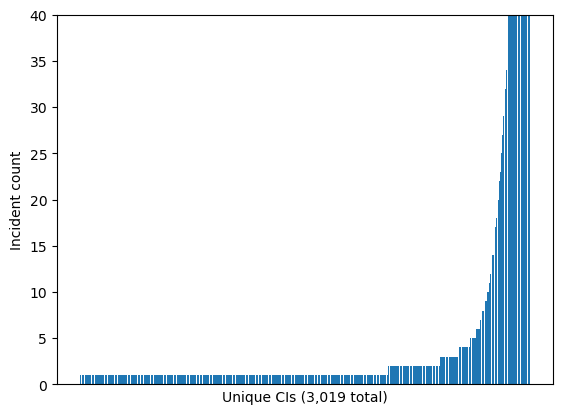

In [42]:
plt.ylim(0, 40)
plt.ylabel("Incident count")
plt.xlabel("Unique CIs (3,019 total)")
plt.xticks([])
plt.bar(data["CI_Name"].value_counts()[::-1].index.tolist(), data["CI_Name"].value_counts()[::-1].values)

<h3>Check distribution of CI subcategory</h3>
We expected an uneven distribution based on the incident rates by CI,
but this is far more lopsided than that metric, with the top 2 subcats
containing 72% of the total incidents, and the gap between the 2nd and 3rd
highest by subcat being 24%;  Server Based Applications and Web Based

In [43]:
inc_by_subcat_rates = data["CI_Subcat"].value_counts()/sum(data["CI_Subcat"].value_counts())
inc_by_subcat_rates

CI_Subcat
Server Based Application           0.404581
Web Based Application              0.329304
Desktop Application                0.083364
Laptop                             0.041316
SAP                                0.025788
                                     ...   
Windows Server in extern beheer    0.000022
Virtual Tape Server                0.000022
RAC Service                        0.000022
NonStop Storage                    0.000022
Protocol                           0.000022
Name: count, Length: 64, dtype: float64